In [108]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import PIL
from typing import List, Any, Optional

# Helper functions

In [80]:
def plot_images(images: List[Any], titles: Optional[List[str]] = None):
    """Plots a list of images with their corresponding titles if given."""
    num_images = len(images)
    fig, axs = plt.subplots(ncols=num_images, figsize=(num_images*5, 5))
    for ax, image in zip(axs.flat, images):
        ax.imshow(image)
        ax.set_title(image.size)

# Torchvision

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

## OxfordIIITPet dataset

We will work with the OxfordIIITPet dataset. This dataset contains images from 37 pets with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. To download it, execute the cell below.

In [7]:
data = torchvision.datasets.OxfordIIITPet(
    root='/data/Courses/bivl2ab-pytorch/datasets/', download=False
)

You can retrieve samples from `data` using the index notation.

In [64]:
image, label = data[10]
print(f"image type: {type(image)}, label type: {type(label)}")

image type: <class 'PIL.Image.Image'>, label type: <class 'int'>


Awesome, the image is represented as a `PIL.Image` object and the label is just an `int`. Next step is to inspect how the image looks like.

Text(0.5, 1.0, 'Image shape: (500, 375, 3)\nlabel: Abyssinian')

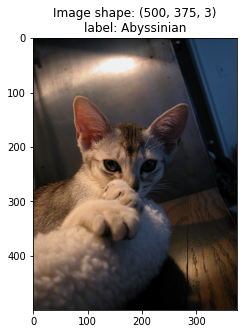

In [65]:
text_label = data.classes[label] # The data object has a list with the class names.
title = f"""\
Image shape: ({image.height}, {image.width}, {len(image.getbands())})
label: {text_label}"""

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(title)

## `torchvision.transforms`

This module contains common image transformations. It's especially useful to build data pipelines for training neural networks in PyTorch. You can take a look at the [documentation](https://pytorch.org/vision/stable/transforms.html) to figure out which methods are available. Take special care with the datatype you're dealing with: 

> Most transformations accept both PIL images and tensor images, although some transformations are PIL-only and some are tensor-only. The Conversion Transforms may be used to convert to and from PIL images.

We will now take a look at some of the most relevant transformations for training neural networks.

### Conversion Transforms

These are transformations that parse/cast one image from one type to another.

#### ToTensor

> <span style="color:red">:exclamation: This transformation is usually the first one in input data pipelines.</span>

From documentation

> Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x > W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, > 1) or if the numpy.ndarray has dtype = np.uint8

In [101]:
to_tensor = torchvision.transforms.ToTensor()
tensor_image = to_tensor(image)

print(f"image type: {type(image)} tensor_image type: {type(tensor_image)}")

image type: <class 'PIL.Image.Image'> tensor_image type: <class 'torch.Tensor'>


#### ToPILImage

From documentation

> Convert a tensor or an ndarray to PIL Image. This transform does not support torchscript. Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape H x W x C to a PIL Image while preserving the value range.

In [112]:
to_pil = torchvision.transforms.ToPILImage()
pil_image = to_pil(tensor_image)

print(f"tensor_image type: {type(tensor_image)}, PIL image type: {type(pil_image)} ")

# Check if the original image and the converted from Torch.tensor are the same.
diff = PIL.ImageChops.difference(image, pil_image)

if diff.getbbox():
    print("image != pil_image")
else:
    print("image == pil_image")

tensor_image type: <class 'torch.Tensor'>, PIL image type: <class 'PIL.Image.Image'> 
image == pil_image


### Deterministic transformations

These are transformations than no matter how many times they are used, they give the same results everytime

#### Resize

From the documentation

> Resize the input image to the given size. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions

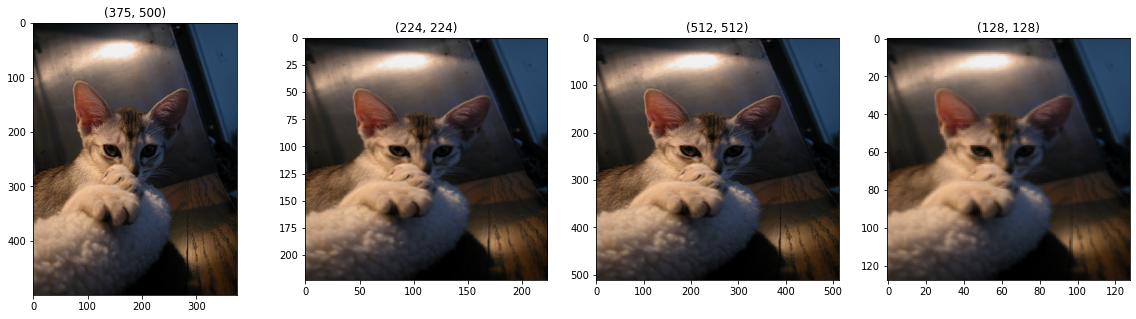

In [88]:
resize_224 = torchvision.transforms.Resize(size=(224, 224))
resize_512 = torchvision.transforms.Resize(size=(512, 512))
resize_128 = torchvision.transforms.Resize(size=(128, 128))

resized_image_224 = resize_224(image)
resized_image_512 = resize_512(image)
resized_image_128 = resize_128(image)

plot_images(
    images=[image, resized_image_224, resized_image_512, resized_image_128], 
    titles=["Original", "Resized 224", "Resized 512", "Resized 128"]
)

One of the interesting things about `Resize` is that you can set the interpolation method to use:

- torchvision.transforms.InterpolationMode.NEAREST
- torchvision.transforms.InterpolationMode.BILINEAR
- torchvision.transforms.InterpolationMode.BICUBIC

False

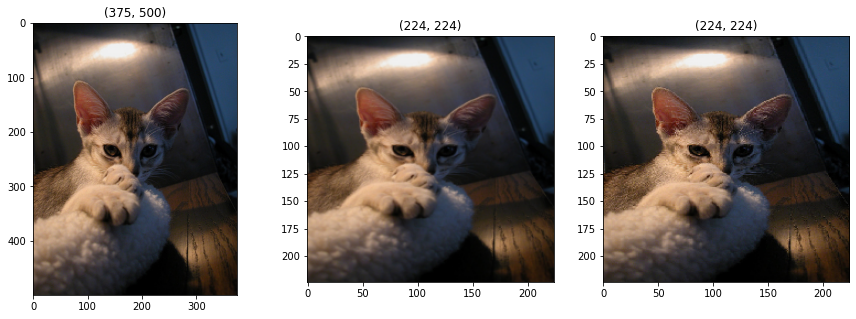

In [90]:
resize_224_nearest = torchvision.transforms.Resize(
    size=(224, 224), interpolation=torchvision.transforms.InterpolationMode.NEAREST
)

resized_image_224_nearest = resize_224_nearest(image)

plot_images(
    images=[image, resized_image_224, resized_image_224_nearest], 
    titles=["Original", "Resized 224", "Resized 224 Nearest"]
)

#### CenterCrop

From the documentation

> Crops the given image at the center. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions. If image size is smaller than output size along any edge, image is padded with 0 and then center cropped.

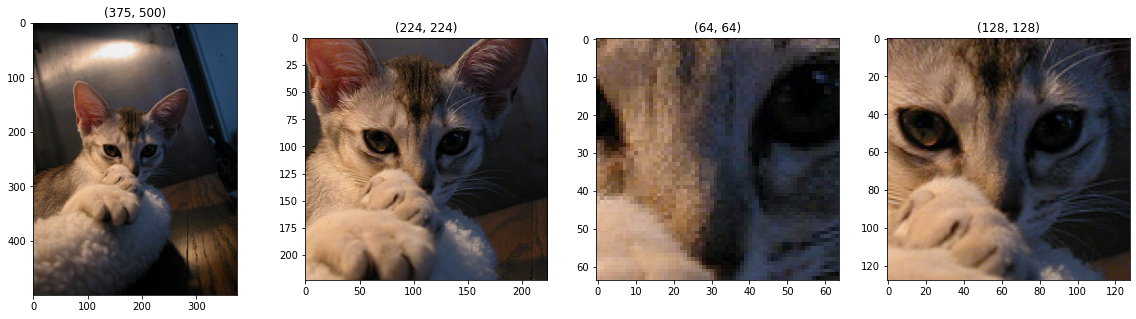

In [91]:
ccrop_224 = torchvision.transforms.CenterCrop(size=(224, 224))
ccrop_64 = torchvision.transforms.CenterCrop(size=(64, 64))
ccrop_128 = torchvision.transforms.CenterCrop(size=(128, 128))

resized_image_224 = ccrop_224(image)
resized_image_64 = ccrop_64(image)
resized_image_128 = ccrop_128(image)

plot_images(
    images=[image, resized_image_224, resized_image_64, resized_image_128], 
    titles=["Original", "Center Crop 224", "Center Crop 512", "Center Crop 128"]
)

### Non-deterministic transformations

These are transformations than could give a different result each time they are called.

#### RandomRotation

From the documentation

> Rotate the image by angle. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions. Range of degrees to select from. If degrees is a number instead of sequence like (min, max), the range of degrees will be (-degrees, +degrees).

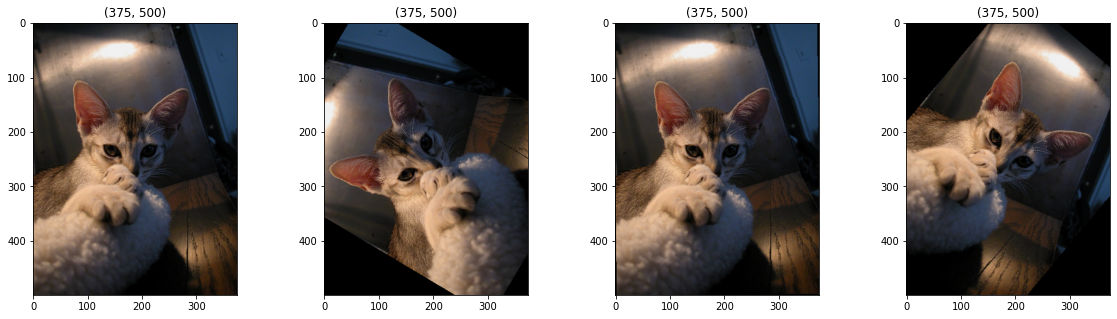

In [92]:
random_rot = torchvision.transforms.RandomRotation(degrees=60)

random_rot_image_1 = random_rot(image)
random_rot_image_2 = random_rot(image)
random_rot_image_3 = random_rot(image)

plot_images(
    images=[image, random_rot_image_1, random_rot_image_2, random_rot_image_3], 
    titles=["Original", "Random rotation 1", "Random rotation 2", "Random rotation 3"]
)

#### RandomVerticalFlip

From the documentation

> Vertically flip the given image randomly with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions


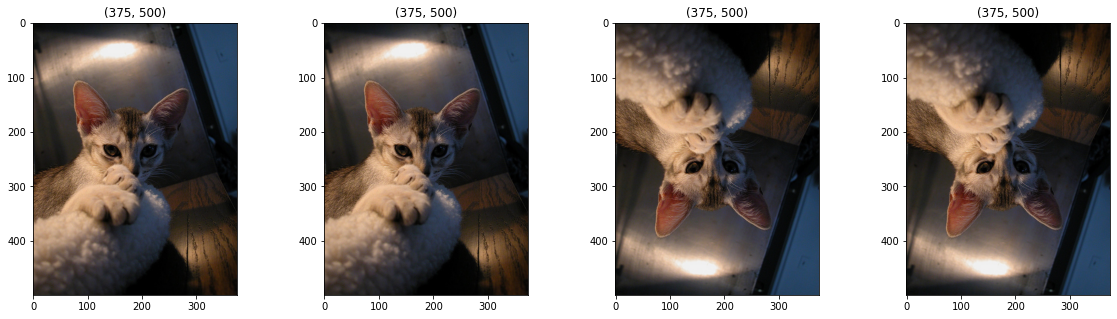

In [96]:
random_vflip = torchvision.transforms.RandomVerticalFlip(p=0.5)

random_vflip_image_1 = random_vflip(image)
random_vflip_image_2 = random_vflip(image)
random_vflip_image_3 = random_vflip(image)

plot_images(
    images=[image, random_vflip_image_1, random_vflip_image_2, random_vflip_image_3], 
    titles=["Original", "Random Vertical Flip 1", "Random Vertical Flip 2", "Random Vertical Flip 3"]
)

#### RandomHorizontalFlip

From the documentation

> Horizontally flip the given image randomly with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions


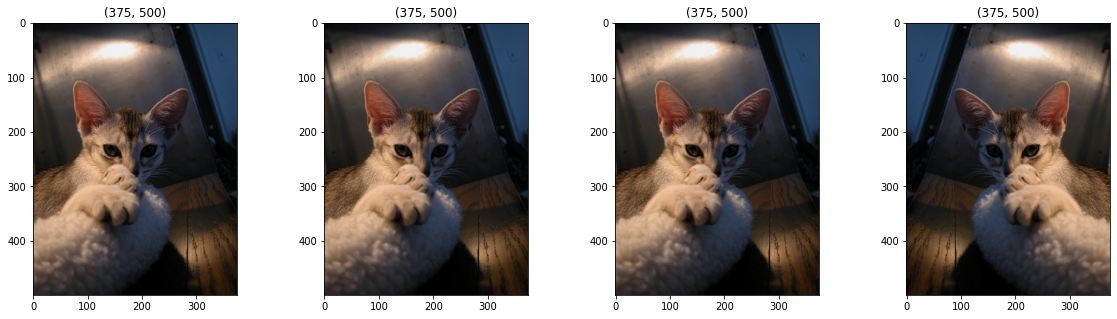

In [97]:
random_hflip = torchvision.transforms.RandomHorizontalFlip(p=0.5)

random_hflip_image_1 = random_hflip(image)
random_hflip_image_2 = random_hflip(image)
random_hflip_image_3 = random_hflip(image)

plot_images(
    images=[image, random_hflip_image_1, random_hflip_image_2, random_hflip_image_3], 
    titles=["Original", "Random Horizontal Flip 1", "Random Horizontal Flip 2", "Random Horizontal Flip 3"]
)

#### RandomResizedCrop

From the documentation

> Crop a random portion of image and resize it to a given size.
> If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions
> A crop of the original image is made: the crop has a random area (H * W) and a random aspect ratio. This crop is finally resized to the given size. This is popularly used to train the Inception networks.


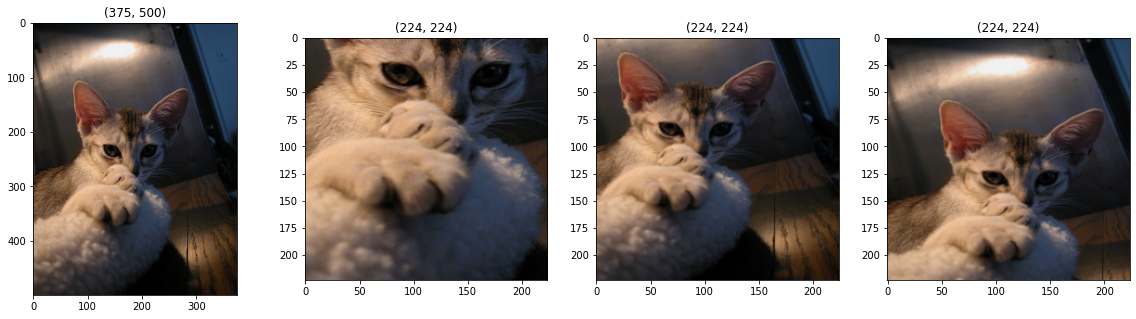

In [98]:
random_resized_crop_224 = torchvision.transforms.RandomResizedCrop(size=(224, 224))

random_rrc224_image_1 = random_resized_crop_224(image)
random_rrc224_image_2 = random_resized_crop_224(image)
random_rrc224_image_3 = random_resized_crop_224(image)

plot_images(
    images=[image, random_rrc224_image_1, random_rrc224_image_2, random_rrc224_image_3], 
    titles=["Original", "Random Resized Crop 224 Flip 1", "Random Resized Crop 224 Flip 2", "Random Resized Crop 224 Flip 3"]
)

### Compose transformations

Until now, we have seen many different transformations from the `torchvision.transforms` module. Nevertheless, several transformations are used in complex input data pipelines. `transforms` have one helpful and easy way to do this.

#### Compose

From documentation

> Composes several transforms together. This transform does not support torchscript. Please, see the note below.

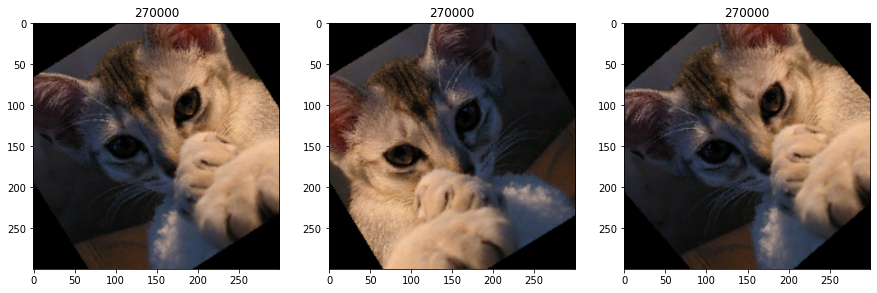

In [121]:
transforms_pipeline = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.Resize(size=(300, 300)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5)
])

transformed_images = [transforms_pipeline(image).numpy().transpose(1, 2, 0) for _ in range(3)]
titles = [f"Transforms pipeline image {i}" for i in range(1, 4)]
plot_images(images=transformed_images, titles=titles)

# References

1. [TRANSFORMING AND AUGMENTING IMAGES WITH TORCHVISION](https://pytorch.org/vision/stable/transforms.html)
2. [Transforms on PIL images and Torch tensors](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor)